## Import Necessary Libraries

In [1]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt
import numpy as np
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report

print(f"Keras version: {keras.__version__}")
print(f"Using backend: {keras.backend.backend()}")

Keras version: 3.12.0
Using backend: tensorflow


## Import Data

In [16]:
#define data paths
TRAINING_DIR = "split_data/training/"
VALIDATION_DIR = "split_data/validation/"
TEST_DIR = "split_data/test/"

## Create Data Generators with Augmentation

In [17]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR, TEST_DIR):
  #create the ImageDataGenerator class for the training set
  train_datagen = ImageDataGenerator(rescale=1./255,
                                     rotation_range=40,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      fill_mode='nearest')
  
  #only apply the rescale transformation to the validation and test sets
  val_test_datagen = ImageDataGenerator(rescale=1./255)

  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=32,
                                                      class_mode='sparse',
                                                      target_size=(224, 224))
  validation_generator = val_test_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                              batch_size=32,
                                                              class_mode='sparse',
                                                              target_size=(224, 224))
  test_generator = val_test_datagen.flow_from_directory(directory=TEST_DIR,
                                                        batch_size=32,
                                                        class_mode='sparse',
                                                        target_size=(224, 224))
  return train_generator, validation_generator, test_generator


In [18]:
#test the generators
train_generator, validation_generator, test_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR, TEST_DIR)

Found 544 images belonging to 3 classes.
Found 155 images belonging to 3 classes.
Found 81 images belonging to 3 classes.


## Baseline CNN model

In [19]:
#define function to create cnn model
def create_model():

  model = keras.models.Sequential([

    keras.layers.Conv2D(32, kernel_size = (3,3), activation="relu", padding="same", input_shape = (224, 224, 3)),
    keras.layers.MaxPooling2D((2, 2)), 

    keras.layers.Conv2D(64, kernel_size = (3,3), activation="relu", padding="same"),
    keras.layers.MaxPooling2D((2, 2)), 

    keras.layers.Conv2D(128, kernel_size = (3,3), activation="relu", padding="same"),
    keras.layers.MaxPooling2D((2, 2)), 

    keras.layers.Conv2D(128, kernel_size = (3,3), activation="relu", padding="same"),
    keras.layers.MaxPooling2D((2, 2)), 
    
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation="relu"), 
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax")

  ])

  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  return model

In [20]:
#create untrained model
cnn_model = create_model()

/Users/sofielangenhuizen/Desktop/STAT_362/stat263-finalproject/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
#model summary
cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,091,530 (49.94 MB)

 Trainable params: 13,091,530 (49.94 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
#set up early stopping
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, start_from_epoch=10,
                           restore_best_weights=True)
]

In [23]:
#train the model
history = cnn_model.fit(train_generator, validation_data=validation_generator, epochs=30, callbacks = callbacks)

Epoch 1/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 558ms/step - accuracy: 0.4577 - loss: 1.2936 - val_accuracy: 0.5613 - val_loss: 1.0017
Epoch 2/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 542ms/step - accuracy: 0.5551 - loss: 1.0271 - val_accuracy: 0.5613 - val_loss: 0.9692
Epoch 3/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 523ms/step - accuracy: 0.5699 - loss: 1.0006 - val_accuracy: 0.6129 - val_loss: 0.9150
Epoch 4/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 549ms/step - accuracy: 0.5735 - loss: 0.9636 - val_accuracy: 0.6258 - val_loss: 0.8496
Epoch 5/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 537ms/step - accuracy: 0.5901 - loss: 0.9486 - val_accuracy: 0.6774 - val_loss: 0.8323
Epoch 6/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 545ms/step - accuracy: 0.5882 - loss: 0.9151 - val_accuracy: 0.6645 - val_loss: 0.7382
Epoch 7/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 549ms/step - accuracy: 0.6066 - loss: 0.8885 - val_accuracy: 0.6645 - val_loss: 0.7826
Epoch 8/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 549ms/step - accuracy: 0.6195 - loss: 0.8742 - val_accuracy

## Display Training Progress

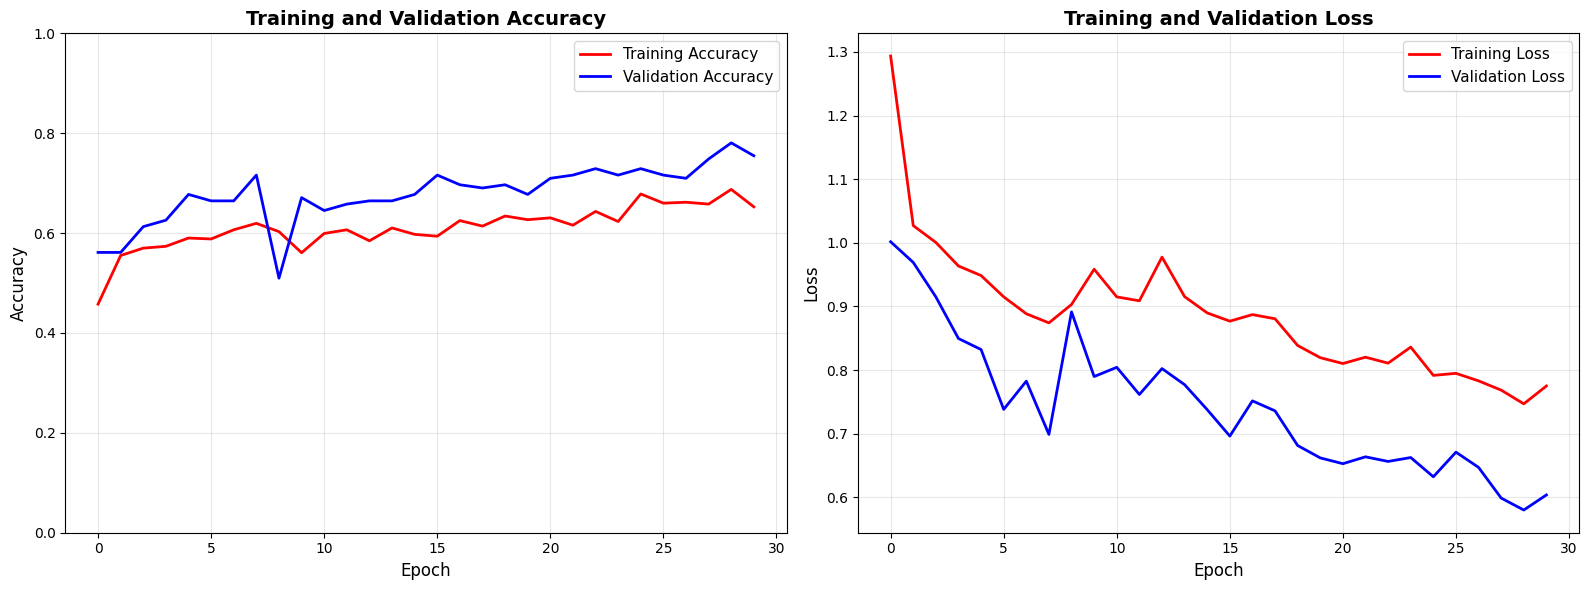


  Training Summary
  Best Training Accuracy:   0.6875 (epoch 29)
  Best Validation Accuracy: 0.7806 (epoch 29)
  Final Training Accuracy:  0.6526
  Final Validation Accuracy:0.7548
  Accuracy Gap (final):     0.1023


In [24]:
#training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

#get number of epochs actually executed with early stopping
epochs_range = range(len(acc))

#create plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

#plot accuracy
ax1.plot(epochs_range, acc, 'r-', linewidth=2, label="Training Accuracy")
ax1.plot(epochs_range, val_acc, 'b-', linewidth=2, label="Validation Accuracy")
ax1.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_ylim([0, 1])

#plot loss
ax2.plot(epochs_range, loss, 'r-', linewidth=2, label="Training Loss")
ax2.plot(epochs_range, val_loss, 'b-', linewidth=2, label="Validation Loss")
ax2.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#print summary stats
print(f"\n{'='*60}")
print(f"  Training Summary")
print(f"{'='*60}")
print(f"  Best Training Accuracy:   {max(acc):.4f} (epoch {acc.index(max(acc))+1})")
print(f"  Best Validation Accuracy: {max(val_acc):.4f} (epoch {val_acc.index(max(val_acc))+1})")
print(f"  Final Training Accuracy:  {acc[-1]:.4f}")
print(f"  Final Validation Accuracy:{val_acc[-1]:.4f}")
print(f"  Accuracy Gap (final):     {abs(acc[-1] - val_acc[-1]):.4f}")
print(f"{'='*60}")

## Evaluate model

In [25]:
#get test accuracy and loss
preds = cnn_model.evaluate(test_generator)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step - accuracy: 0.7037 - loss: 0.7217
Loss = 0.7216835021972656
Test Accuracy = 0.7037037014961243


In [12]:
#evaluate on val set
validation_generator.shuffle = False
y_true = validation_generator.classes
y_pred_probs = cnn_model.predict(validation_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

print("Val Classification Report:")
print(classification_report(y_true, y_pred, target_names=validation_generator.class_indices.keys()))

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 242ms/step
Val Classification Report:
              precision    recall  f1-score   support

      benign       0.58      0.79      0.67        87
   malignant       0.46      0.39      0.42        41
      normal       0.00      0.00      0.00        25

    accuracy                           0.56       153
   macro avg       0.35      0.39      0.36       153
weighted avg       0.46      0.56      0.50       153



/Users/sofielangenhuizen/Desktop/STAT_362/stat263-finalproject/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/sofielangenhuizen/Desktop/STAT_362/stat263-finalproject/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/sofielangenhuizen/Desktop/STAT_362/stat263-finalproject/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted sampl

In [13]:
#evaluate on test set
test_generator.shuffle = False
y_true = test_generator.classes
y_pred_probs = cnn_model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

print("Test Classification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step
Test Classification Report:
              precision    recall  f1-score   support

      benign       0.50      0.66      0.57        44
   malignant       0.13      0.14      0.13        22
      normal       0.00      0.00      0.00        15

    accuracy                           0.40        81
   macro avg       0.21      0.27      0.23        81
weighted avg       0.31      0.40      0.35        81



/Users/sofielangenhuizen/Desktop/STAT_362/stat263-finalproject/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/sofielangenhuizen/Desktop/STAT_362/stat263-finalproject/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/sofielangenhuizen/Desktop/STAT_362/stat263-finalproject/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted sampl

In [14]:
#evaluate on train set
train_generator.shuffle = False
y_true = train_generator.classes
y_pred_probs = cnn_model.predict(train_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

print("Train Classification Report:")
print(classification_report(y_true, y_pred, target_names=train_generator.class_indices.keys()))

18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 343ms/step
Train Classification Report:
              precision    recall  f1-score   support

      benign       0.55      0.75      0.64       306
   malignant       0.24      0.21      0.22       147
      normal       0.00      0.00      0.00        93

    accuracy                           0.48       546
   macro avg       0.26      0.32      0.29       546
weighted avg       0.38      0.48      0.42       546



/Users/sofielangenhuizen/Desktop/STAT_362/stat263-finalproject/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/sofielangenhuizen/Desktop/STAT_362/stat263-finalproject/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/sofielangenhuizen/Desktop/STAT_362/stat263-finalproject/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted sampl